# ========================================
# PHIUSIIL PHISHING DETECTION
# ========================================

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import hashlib
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss, confusion_matrix,
    precision_recall_curve, auc, RocCurveDisplay,
    PrecisionRecallDisplay)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import permutation_importance

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ------------- 0. Reproducibility Setup -------------

In [5]:
SEED = 42
np.random.seed(SEED)
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# -------------- 1. Load & Basic Integrity --------------

In [6]:
print("Loading dataset...")
df = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

print(f"Original shape: {df.shape}")
print(f"Label distribution:\n{df['Label'].value_counts()}")

# 1.1 Remove exact duplicates (URLs)
initial_hash = hashlib.sha256(pd.util.hash_pandas_object(df).values).hexdigest()
n_before = len(df)
df = df.drop_duplicates(subset=['URL'])
print(f"Removed {n_before - len(df):,} exact duplicate URLs")

# 1.2 Target encoding (0=legitimate, 1=phishing)
#df['label'] = df['Label'].map({'legitimate': 0, 'phishing': 1})
y = df['Label']

# if y contains nulls:
if y.isnull().any():
    df = df.dropna(subset=['Label'])
    y = df['Label']
print(f"Label distribution after cleaning:\n{y.value_counts()}")

# Drop non-feature columns
drop_cols = ['FILENAME', 'URL', 'Domain', 'TLD', 'Title']  # high-cardinality + obvious leakers
new_df = df.drop(columns=drop_cols)


Loading dataset...
Original shape: (235795, 56)
Label distribution:
Label
1    134850
0    100945
Name: count, dtype: int64
Removed 425 exact duplicate URLs
Label distribution after cleaning:
Label
1    134850
0    100520
Name: count, dtype: int64



FEATURE CORRELATION ANALYSIS


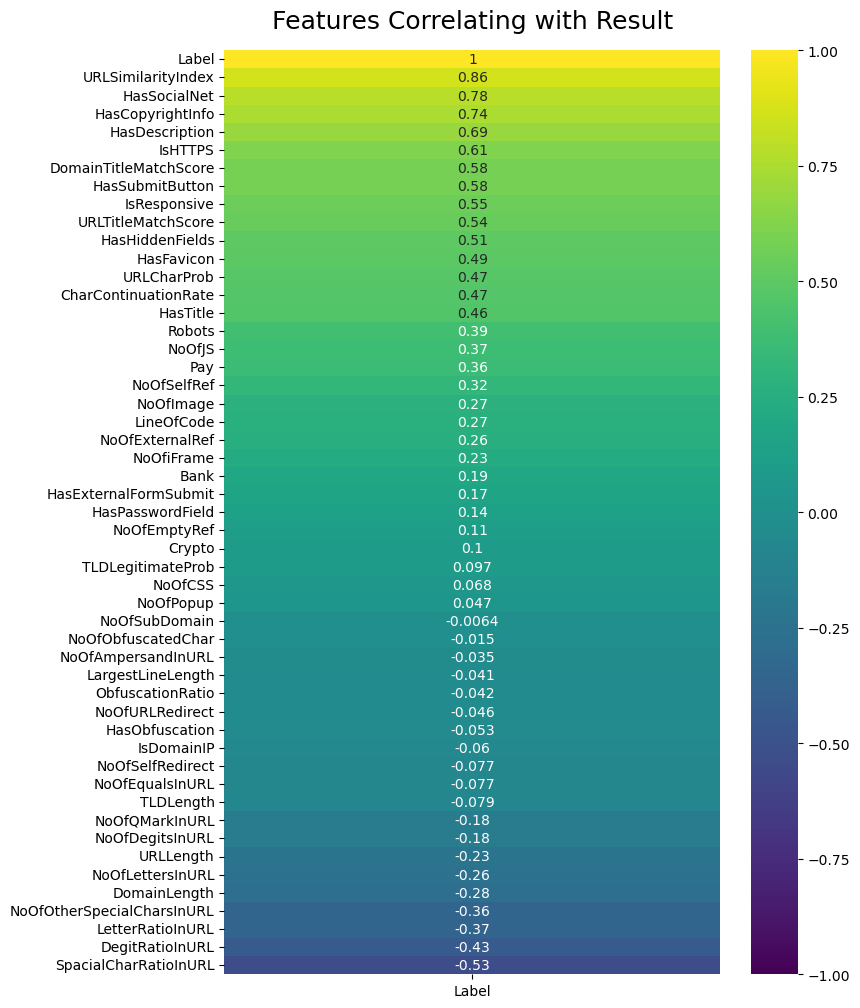

In [7]:
print("\n" + "="*80)
print("FEATURE CORRELATION ANALYSIS")
print("="*80)

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(new_df.corr()[['Label']].sort_values(by='Label', ascending=False), vmin=-1, vmax=1, annot=True, cmap = 'viridis')
heatmap.set_title('Features Correlating with Result', fontdict={'fontsize':18}, pad=16);
plt.savefig('heatmapfeaturecorr.png', dpi=300, bbox_inches='tight')

In [8]:
# --- Detect highly correlated feature pairs ---
corr_matrix = new_df.corr()

high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'].abs() > 0.90]

low_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
low_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
low_corr_pairs = low_corr_pairs[low_corr_pairs['Correlation'].abs() < -0.1]
print("\nLow correlated feature pairs (|corr| < 0.1):")
print(low_corr_pairs if len(low_corr_pairs) > 0 else "None")

print("\nHighly correlated feature pairs (|corr| > 0.9):")
print(high_corr_pairs if len(high_corr_pairs) > 0 else "None")

# OPTIONAL: Remove highly correlated features (to reduce multicollinearity)
remove_corr_features = []
for f1, f2, c in high_corr_pairs.values:
    remove_corr_features.append(f2)

remove_corr_features = list(set(remove_corr_features))

print(f"\nRecommended features to remove due to multicollinearity: {remove_corr_features}")


print(f"Features after dropping obvious leakers: {new_df.shape[1]}")
print("Categorical columns:", list(new_df.select_dtypes(include=['object']).columns))





Low correlated feature pairs (|corr| < 0.1):
None

Highly correlated feature pairs (|corr| > 0.9):
                  Feature1            Feature2  Correlation
11               URLLength    NoOfLettersInURL     0.956046
950  DomainTitleMatchScore  URLTitleMatchScore     0.961166

Recommended features to remove due to multicollinearity: ['URLTitleMatchScore', 'NoOfLettersInURL']
Features after dropping obvious leakers: 51
Categorical columns: []


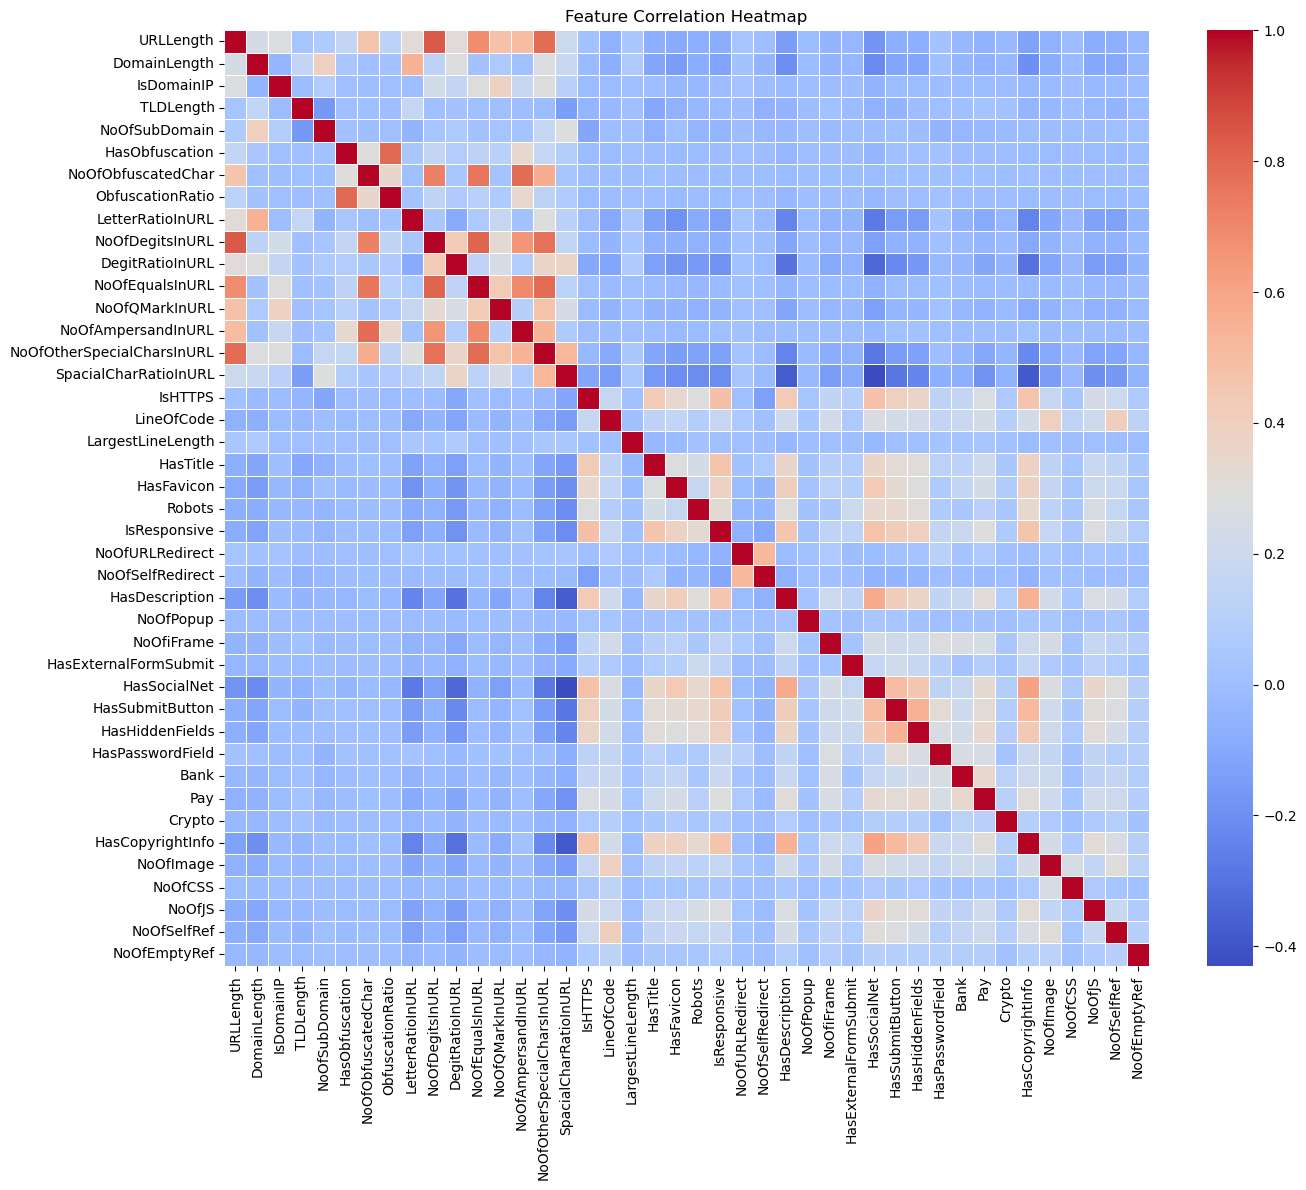

In [27]:
# Drop columns with obvious data leakage
X_raw = new_df.drop(columns=['Label', 'URLSimilarityIndex', 'DomainTitleMatchScore', 'URLTitleMatchScore',
                   'TLDLegitimateProb', 'URLCharProb', 'CharContinuationRate', 'NoOfLettersInURL', 'NoOfExternalRef'])
# Ensure all columns in X_raw are numeric (drop any remaining object columns)
X_raw = X_raw.select_dtypes(include=[np.number])
# Convert all numeric so correlation works
X_numeric = X_raw.apply(pd.to_numeric, errors='coerce')

# --- Compute correlation matrix ---
corr_matrix_final = X_numeric.corr()

# --- Plot heatmap  ---

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix_final,
    cmap="coolwarm",
    annot=False,
    linewidths=0.5
)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

### 🏆 Top 15 Features Ranked by XGBoost Gain ###
                       Feature  Importance
17                  LineOfCode    0.399399
40                 NoOfSelfRef    0.328322
29                HasSocialNet    0.108140
14  NoOfOtherSpecialCharsInURL    0.044037
0                    URLLength    0.043398
4                NoOfSubDomain    0.016423
16                     IsHTTPS    0.013982
37                   NoOfImage    0.013923
25              HasDescription    0.009407
36            HasCopyrightInfo    0.005264
9              NoOfDegitsInURL    0.003296
8             LetterRatioInURL    0.002387
11             NoOfEqualsInURL    0.002100
39                      NoOfJS    0.001614
38                     NoOfCSS    0.001338


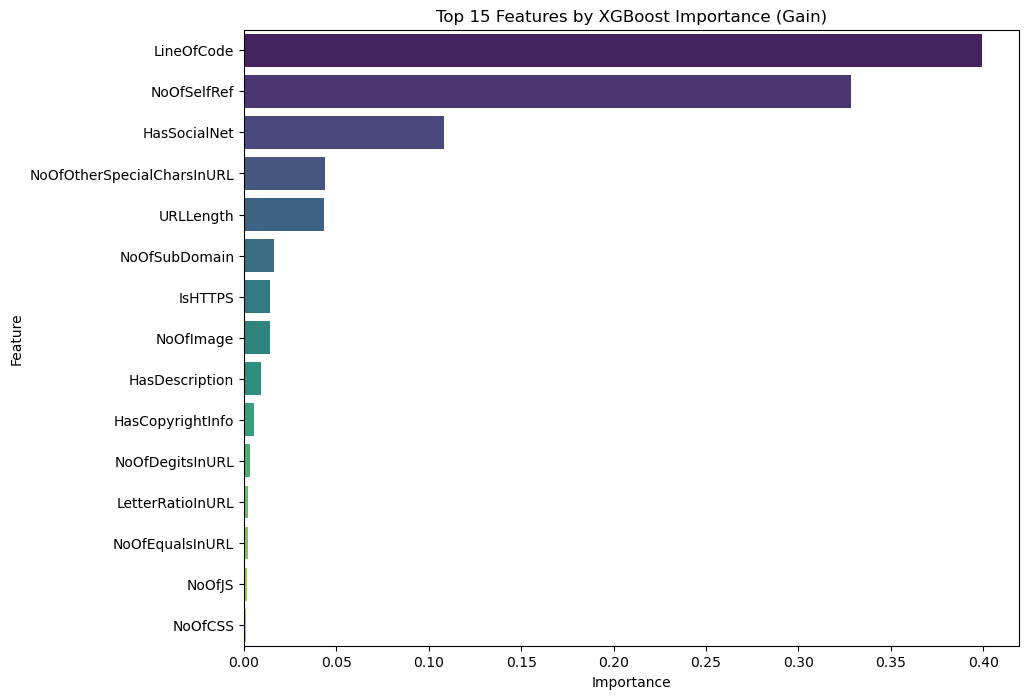


Recommended number of features to keep (Importance > 0.01): 8
Recommended features: ['LineOfCode', 'NoOfSelfRef', 'HasSocialNet', 'NoOfOtherSpecialCharsInURL', 'URLLength', 'NoOfSubDomain', 'IsHTTPS', 'NoOfImage']


In [28]:
feature_names = X_numeric.columns.tolist()

# -----------------------------
# 1. Train XGBoost Model
# -----------------------------
# We use a simple binary classifier for feature importance calculation
xgb_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model on the scaled training data
# Note: XGBoost can handle raw features, but we stick to the scaled data for consistency.
xgb_model.fit(X_numeric, y)

# -----------------------------
# 2. Extract Feature Importance
# -----------------------------
# The feature importance is based on 'gain' by default in recent versions,
# which measures the average gain (improvement in accuracy/loss) of splits
# that use the feature across all trees in the ensemble.
importance_scores = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# -----------------------------
# 3. Print and Plot Results
# -----------------------------
print("### 🏆 Top 15 Features Ranked by XGBoost Gain ###")
print(importance_df.head(15))

# Plot the top 15 most important features
top_n = 15
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df.head(top_n),
    palette='viridis'
)
plt.title(f'Top {top_n} Features by XGBoost Importance (Gain)')
plt.show()

# -----------------------------
# 4. Feature Selection Recommendation
# -----------------------------
# Select features that contribute significantly (e.g., importance > 0.01)
# You can adjust this threshold based on the distribution of your scores.
important_features = importance_df[importance_df['Importance'] > 0.01]['Feature'].tolist()
print(f"\nRecommended number of features to keep (Importance > 0.01): {len(important_features)}")
print("Recommended features:", important_features)

# ---------- 2. Strict Train/Val/Test Split ----------

In [31]:

# Build a domain_series in a robust way (prefer URL, fallback to Domain)
if 'URL' in df.columns and df['URL'].notna().any():
    domain_series = df['URL'].str.extract(r'://([^/]+)')[0].str.split('.').str[-2:].str.join('.')
elif 'Domain' in df.columns and df['Domain'].notna().any():
    domain_series = df['Domain'].astype(str)
else:
    # No domain information available -> empty series aligned to df
    domain_series = pd.Series(index=df.index, dtype=object)

unique_domains = domain_series.dropna().unique()

# Try domain-level stratified split if there are enough domains; otherwise fallback to sample-level split
if len(unique_domains) > 1:
    # Use the numeric label column ('Label') for aggregation if available
    if 'Label' in df.columns:
        domain_label_map = df.groupby(domain_series)['Label'].agg(lambda x: (x == 1).sum() > (x == 0).sum()).astype(int)
    else:
        # fallback: if only string Label exists use that
        domain_label_map = df.groupby(domain_series)['Label'].agg(lambda x: (x == 'phishing').sum() > (x == 'legitimate').sum()).astype(int)

    stratify_targets = domain_label_map.reindex(unique_domains).fillna(0).astype(int).values

    try:
        train_domains, temp_domains = train_test_split(
            unique_domains, test_size=0.4, random_state=SEED, stratify=stratify_targets
        )
        val_domains, test_domains = train_test_split(
            temp_domains, test_size=0.5, random_state=SEED
        )

        train_idx = df[domain_series.isin(train_domains)].index
        val_idx   = df[domain_series.isin(val_domains)].index
        test_idx  = df[domain_series.isin(test_domains)].index

    except ValueError:
        # Domain split failed (e.g. too few domains for stratify) -> fallback to sample-level stratified split
        if y.notna().any():
            train_idx, temp_idx = train_test_split(df.index, test_size=0.4, random_state=SEED, stratify=y)
            # stratify on labels within the temp set if possible
            if y.loc[temp_idx].nunique() > 1:
                val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=SEED, stratify=y.loc[temp_idx])
            else:
                val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=SEED)
        else:
            train_idx, temp_idx = train_test_split(df.index, test_size=0.4, random_state=SEED)
            val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=SEED)

else:
    # Not enough domains; perform sample-level split (stratify by label if available)
    if y.notna().any() and y.nunique() > 1:
        train_idx, temp_idx = train_test_split(df.index, test_size=0.4, random_state=SEED, stratify=y)
        # Keep stratification for val/test if possible
        if y.loc[temp_idx].nunique() > 1:
            val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=SEED, stratify=y.loc[temp_idx])
        else:
            val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=SEED)
    else:
        train_idx, temp_idx = train_test_split(df.index, test_size=0.4, random_state=SEED)
        val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=SEED)

# Build the splits for features/targets
X_train_raw, X_val_raw, X_test_raw = X_raw.loc[train_idx], X_raw.loc[val_idx], X_raw.loc[test_idx]
y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]

print(f"Train: {len(X_train_raw):,} | Val: {len(X_val_raw):,} | Test: {len(X_test_raw):,} ")

Train: 139,282 | Val: 47,435 | Test: 48,653 


# ------------- 3. Final Feature List -------------

In [32]:
categorical_cols = X_train_raw.select_dtypes(include=['object']).columns.tolist()
numerical_cols   = X_train_raw.select_dtypes(exclude=['object']).columns.tolist()

print(f"Categorical features: {len(categorical_cols)}")
print(f"Numerical features:   {len(numerical_cols)}")

Categorical features: 0
Numerical features:   42


# ---------- 4. Pipeline Construction ------------

In [13]:
def get_pipeline(model, use_smote=True, use_pca=True):
    steps = []

    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', 'passthrough', categorical_cols)
        ], remainder='passthrough'
    )
    steps.append(('preprocessor', preprocessor))

    if use_smote:
        steps.append(('smote', SMOTE(random_state=SEED)))

    if use_pca:
        steps.append(('pca', PCA(n_components=0.95, random_state=SEED)))

    steps.append(('classifier', model))

    return ImbPipeline(steps) if use_smote else Pipeline(steps)

In [14]:
gc.collect()

15

# ------------------- 5. Models Defination --------------------

In [15]:
models_config = {
    "Logistic Regression": {
        "model": LogisticRegression(
            max_iter=2000,
            class_weight='balanced',
            solver='lbfgs',
            penalty='l2'
        ),
        "smote": True, "pca": True
    },

    "Random Forest": {
        "model": RandomForestClassifier(
            n_estimators=300,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced_subsample',
            n_jobs=-1,
            random_state=SEED
        ),
        "smote": True, "pca": True
    },

    "Extra Trees": {
        "model": ExtraTreesClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            n_jobs=-1,
            random_state=SEED
        ),
        "smote": True, "pca": True
    },

    "XGBoost": {
        "model": XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.03,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=0.1,
            reg_lambda=1.0,
            scale_pos_weight=1,
            n_jobs=-1,
            random_state=SEED,
            eval_metric='logloss'
        ),
        "smote": True, "pca": True
    },

    "MLP": {
        "model": MLPClassifier(
            hidden_layer_sizes=(256, 64, 16),
            learning_rate='adaptive',
            alpha=0.0005,
            max_iter=2000,
            early_stopping=True,
            validation_fraction=0.15,
            random_state=SEED
        ),
        "smote": True, "pca": True
    },

    "SVM (RBF)": {
        "model": SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            class_weight='balanced',
            probability=True,
            random_state=SEED
        ),
        "smote": True, "pca": True
    },

    "Decision Tree (J48)": {
        "model": DecisionTreeClassifier(
            criterion='entropy',
            max_depth=15,
            min_samples_leaf=3,
            class_weight='balanced',
            random_state=SEED
        ),
        "smote": True, "pca": True
    },

    "AdaBoost": {
        "model": AdaBoostClassifier(
            n_estimators=200,
            learning_rate=0.5,
            random_state=SEED
        ),
        "smote": True, "pca": True
    },

    "Gradient Boosting": {
        "model": GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8
        ),
        "smote": True, "pca": True
    },

    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(
            n_neighbors=7,
            weights='distance',
            p=2
        ),
        "smote": True, "pca": True
    },

    "Naïve Bayes": {
        "model": BernoulliNB(
            alpha=1.0,
            binarize=0.0,
            fit_prior=True,
            class_prior=None
        ),
        "smote": True, "pca": True
    },

    "Linear Discriminant": {
        "model": LinearDiscriminantAnalysis(
            solver='lsqr',
            shrinkage='auto',
            n_components=None,
            tol=1e-4,
            store_covariance=True
        ),
        "smote": True, "pca": True
    }
}

# ---------------- 6. Training + Evaluation Loop ----------------

In [16]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

results = []

print("\n" + "="*60)
print("TRAINING MODELS WITH PROPER SIGMID/ISOTONIC CALIBRATION (NO LEAKAGE)")
print("="*60)

for name, cfg in models_config.items():
    print(f"\nTraining {name}...", end="")

    # Build pipeline (preprocessing + SMOTE/PCA if needed)
    pipe = get_pipeline(cfg["model"], use_smote=cfg["smote"], use_pca=cfg["pca"])

    # Fit on training data only
    pipe.fit(X_train_raw, y_train)
    print(" [Trained]")

    # === Choose calibration method heuristically ===
    # Use isotonic for tree-based / big models where isotonic is beneficial
    isotonic_candidates = {
        "Random Forest", "Extra Trees", "XGBoost", "Gradient Boosting",
        "AdaBoost", "MLP"
    }
    cal_method = "isotonic" if name in isotonic_candidates else "sigmoid"
    # fallback safety
    cal_cv = 10

    # Attempt calibration in a guarded way (n_jobs=1 avoids ResourceTracker bug)
    calibrator = pipe  # default fallback if calibration fails / not supported
    try:
        # Try to create and fit a CalibratedClassifierCV on the pipeline
        print(f"  → Attempting {cal_method} calibration for {name}...", end="")
        calibrator = CalibratedClassifierCV(
            estimator=pipe,
            method=cal_method,
            cv=cal_cv,
            n_jobs=1  # important: avoids multiprocessing ResourceTracker warnings
        )
        # Note: fit on training data ONLY to avoid leakage
        calibrator.fit(X_train_raw, y_train)
        print(" [Calibrated]")
        calibrated_ok = True
    except Exception as e:
        # If calibration fails for any reason (no predict_proba, SVC with probability=False, etc.)
        print(f" [Calibration skipped: {e}]")
        calibrator = pipe
        calibrated_ok = False

    # === PREDICTIONS & PROBABILITIES (robust) ===
    # Predict labels
    y_pred = calibrator.predict(X_test_raw)

    # Try predict_proba -> decision_function -> fallback (None)
    y_proba = None
    try:
        if hasattr(calibrator, "predict_proba") and callable(getattr(calibrator, "predict_proba", None)):
            y_proba = calibrator.predict_proba(X_test_raw)[:, 1]
        else:
            raise AttributeError("predict_proba not available on calibrator")
    except Exception:
        # Try decision_function and min-max scale to [0,1]
        try:
            if hasattr(calibrator, "decision_function") and callable(getattr(calibrator, "decision_function", None)):
                df_scores = calibrator.decision_function(X_test_raw)
                # If df_scores is 2D (multiclass), try to reduce — keep second column if binary-like
                if df_scores.ndim == 2 and df_scores.shape[1] > 1:
                    # pick column of positive class if possible
                    df_scores = df_scores[:, 1]
                # min-max scaling
                minv, maxv = df_scores.min(), df_scores.max()
                if maxv > minv:
                    y_proba = (df_scores - minv) / (maxv - minv)
                else:
                    y_proba = np.full_like(df_scores, 0.5, dtype=float)
            else:
                y_proba = None
        except Exception:
            y_proba = None

    # Compute confusion matrix and basic label metrics (these do not require probabilities)
    try:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    except Exception:
        # If confusion_matrix fails (edge cases), set zeros
        tn = fp = fn = tp = 0

    # Compute PR-AUC, ROC-AUC, Brier if we have probabilities; otherwise set NaN
    pr_auc = np.nan
    roc_auc = np.nan
    brier = np.nan

    if y_proba is not None:
        try:
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            pr_auc = auc(recall, precision)
        except Exception:
            pr_auc = np.nan

        try:
            roc_auc = roc_auc_score(y_test, y_proba)
        except Exception:
            roc_auc = np.nan

        try:
            brier = brier_score_loss(y_test, y_proba)
        except Exception:
            brier = np.nan

    # Compute label-based metrics (safe)
    try:
        accuracy = accuracy_score(y_test, y_pred)
        precision_val = precision_score(y_test, y_pred, zero_division=0)
        recall_val = recall_score(y_test, y_pred, zero_division=0)
        f1_val = f1_score(y_test, y_pred, zero_division=0)
    except Exception:
        accuracy = precision_val = recall_val = f1_val = np.nan

    # Store results
    results.append({
        "Model": name,
        "Accuracy": round(float(accuracy), 5) if not np.isnan(accuracy) else np.nan,
        "Precision": round(float(precision_val), 5) if not np.isnan(precision_val) else np.nan,
        "Recall": round(float(recall_val), 5) if not np.isnan(recall_val) else np.nan,
        "F1": round(float(f1_val), 5) if not np.isnan(f1_val) else np.nan,
        "ROC-AUC": round(float(roc_auc), 5) if not np.isnan(roc_auc) else np.nan,
        "PR-AUC": round(float(pr_auc), 5) if not np.isnan(pr_auc) else np.nan,
        "Brier": round(float(brier), 5) if not np.isnan(brier) else np.nan,
        "FNR (%)": round(100 * fn / (fn + tp), 3) if (fn + tp) > 0 else np.nan,
        "FPR (%)": round(100 * fp / (fp + tn), 3) if (fp + tn) > 0 else np.nan,
        "Errors": int(fp + fn),
        "TP/TN/FP/FN": f"{tp}/{tn}/{fp}/{fn}"
    })

    # Save predictions for plotting later (include y_proba if available)
    preds_df = pd.DataFrame({
        'y_true': y_test.values if hasattr(y_test, 'values') else np.array(y_test),
        'y_pred': y_pred,
        'y_proba': y_proba if y_proba is not None else np.nan
    })
    preds_df.to_csv(RESULTS_DIR / f"predictions_{name}.csv", index=False)

    # Clean up memory
    gc.collect()

# Final results
results_df = pd.DataFrame(results)
# Sort by ROC-AUC if available else PR-AUC, filling NaN with -inf so they go to the bottom
results_df["sort_key"] = results_df["ROC-AUC"].fillna(-999)
results_df = results_df.sort_values("sort_key", ascending=False).drop(columns=["sort_key"]).reset_index(drop=True)

print("\n" + "="*80)
print("FINAL RESULTS – STRICT DOMAIN SPLIT + SIGMOID/ISOTONIC CALIBRATION + NO LEAKAGE")
print("="*80)
display(results_df)

# Save master table
results_df.to_csv(RESULTS_DIR / "final_results_calibrated.csv", index=False)
print(f"\nAll results saved to {RESULTS_DIR}/")


TRAINING MODELS WITH PROPER SIGMID/ISOTONIC CALIBRATION (NO LEAKAGE)

Training Logistic Regression... [Trained]
  → Attempting sigmoid calibration for Logistic Regression... [Calibrated]

Training Random Forest... [Trained]
  → Attempting isotonic calibration for Random Forest... [Calibrated]

Training Extra Trees... [Trained]
  → Attempting isotonic calibration for Extra Trees... [Calibrated]

Training XGBoost... [Trained]
  → Attempting isotonic calibration for XGBoost... [Calibrated]

Training MLP... [Trained]
  → Attempting isotonic calibration for MLP... [Calibrated]

Training SVM (RBF)... [Trained]
  → Attempting sigmoid calibration for SVM (RBF)... [Calibrated]

Training Decision Tree (J48)... [Trained]
  → Attempting sigmoid calibration for Decision Tree (J48)... [Calibrated]

Training AdaBoost... [Trained]
  → Attempting isotonic calibration for AdaBoost... [Calibrated]

Training Gradient Boosting... [Trained]
  → Attempting isotonic calibration for Gradient Boosting... [Cali

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC,Brier,FNR (%),FPR (%),Errors,TP/TN/FP/FN
0,Logistic Regression,0.99928,0.99905,0.99962,0.99934,0.99998,0.99998,0.00064,0.038,0.112,35,26347/22271/25/10
1,SVM (RBF),0.99864,0.99784,0.99966,0.99875,0.99998,0.99999,0.00091,0.034,0.256,66,26348/22239/57/9
2,MLP,0.99963,0.99939,0.99992,0.99966,0.99997,0.99997,0.00030,0.008,0.072,18,26355/22280/16/2
3,Gradient Boosting,0.99805,0.99788,0.99852,0.99820,0.99996,0.99996,0.00159,0.148,0.251,95,26318/22240/56/39
4,XGBoost,0.99895,0.99867,0.99939,0.99903,0.99994,0.99995,0.00085,0.061,0.157,51,26341/22261/35/16
5,AdaBoost,0.99688,0.99708,0.99715,0.99712,0.99993,0.99993,0.00226,0.285,0.345,152,26282/22219/77/75
6,Random Forest,0.99825,0.99795,0.99882,0.99839,0.99992,0.99992,0.00131,0.118,0.242,85,26326/22242/54/31
7,Extra Trees,0.99871,0.99867,0.99894,0.99881,0.99992,0.99992,0.00111,0.106,0.157,63,26329/22261/35/28
8,Decision Tree (J48),0.99852,0.99803,0.99924,0.99863,0.99981,0.99983,0.00148,0.076,0.233,72,26337/22244/52/20
9,Linear Discriminant,0.99157,0.99335,0.99108,0.99221,0.99972,0.99975,0.00596,0.892,0.785,410,26122/22121/175/235



All results saved to results/


# ----------------- 7. Plots -----------------

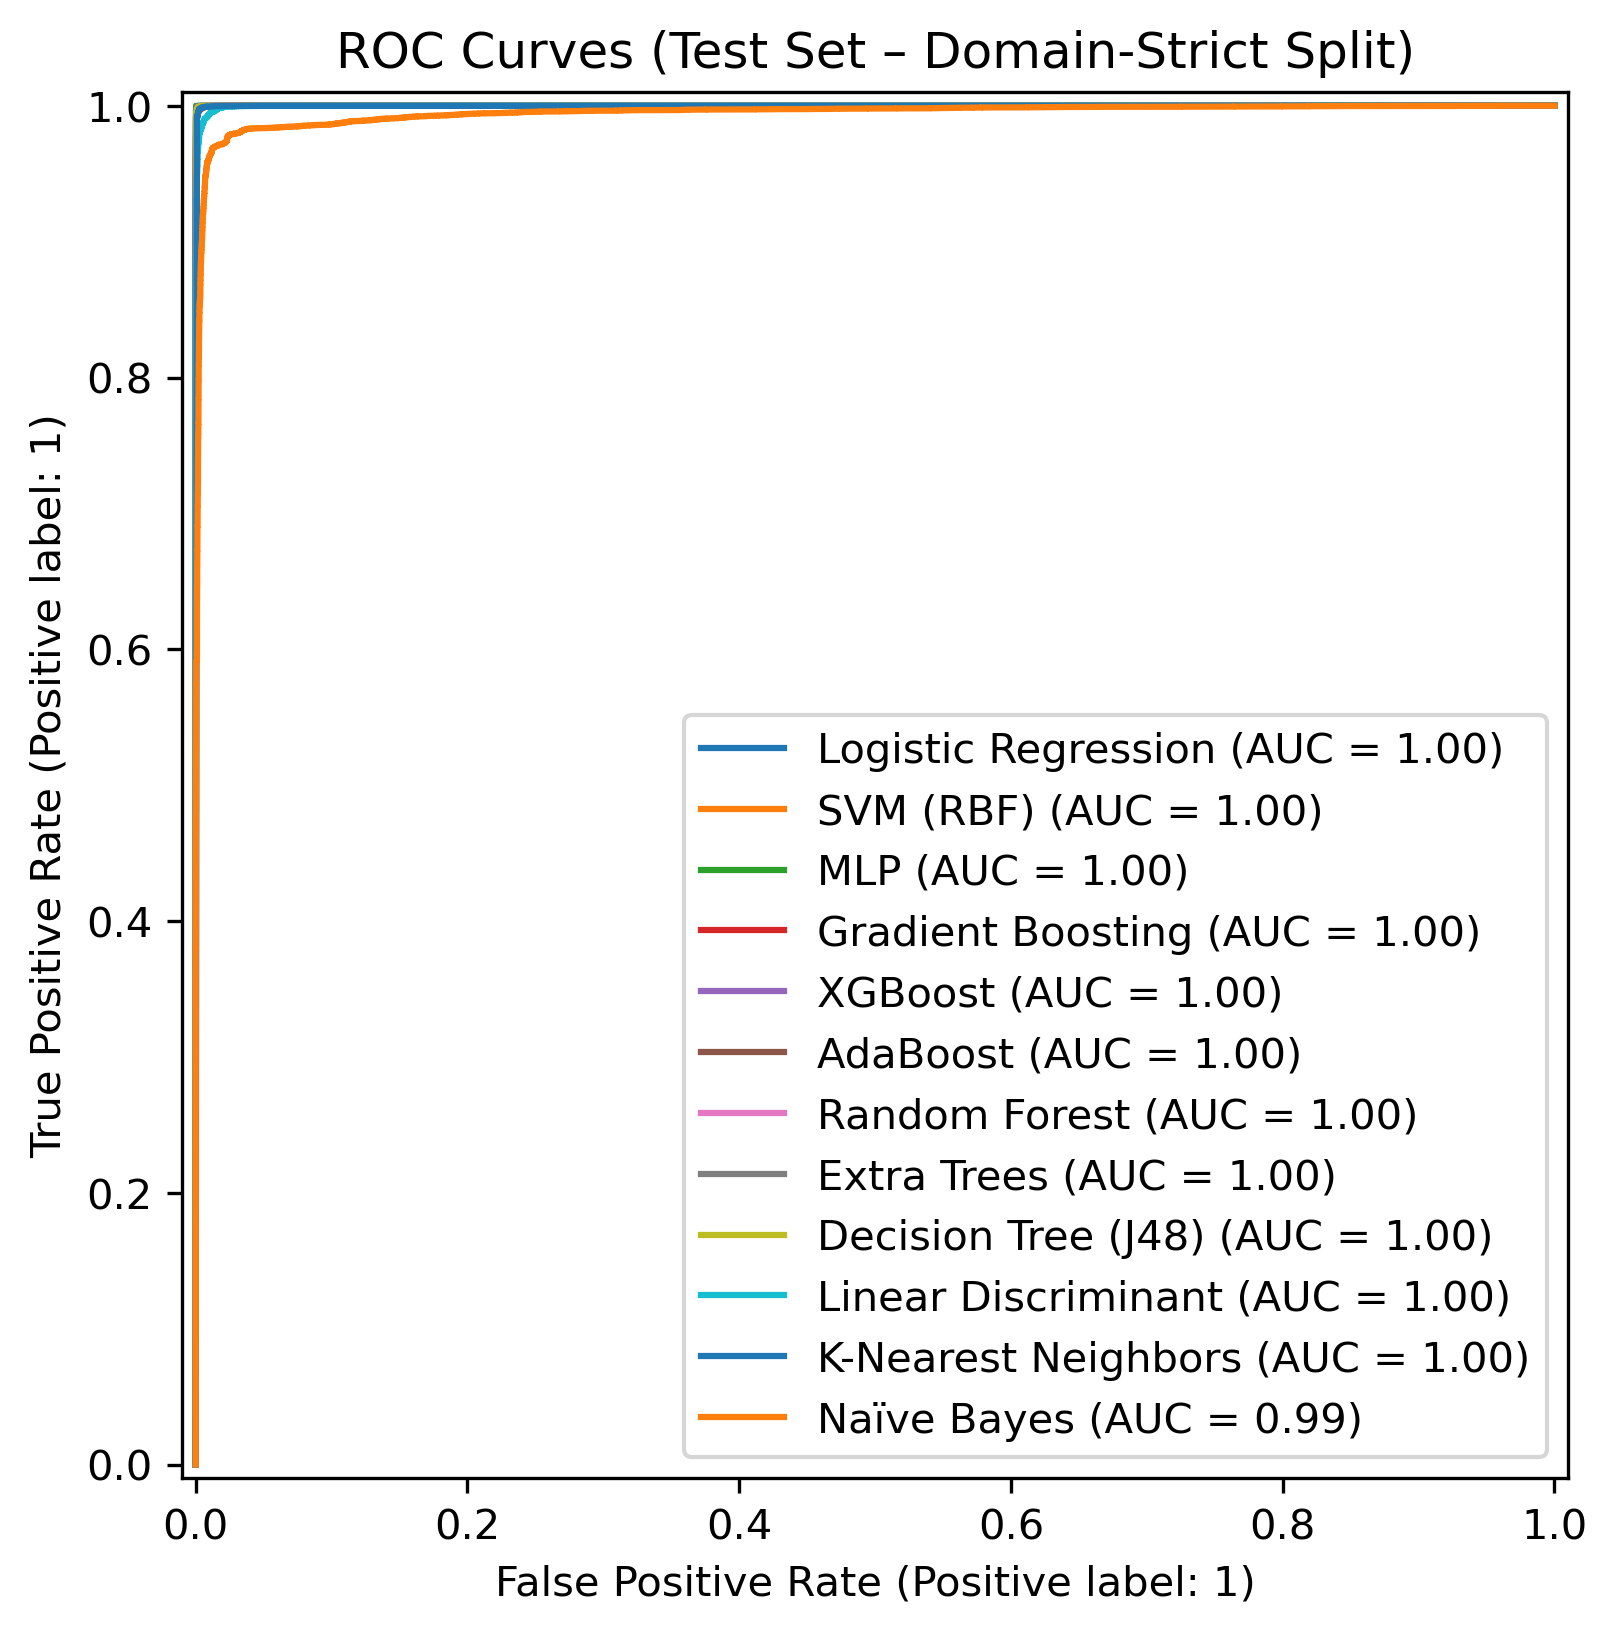

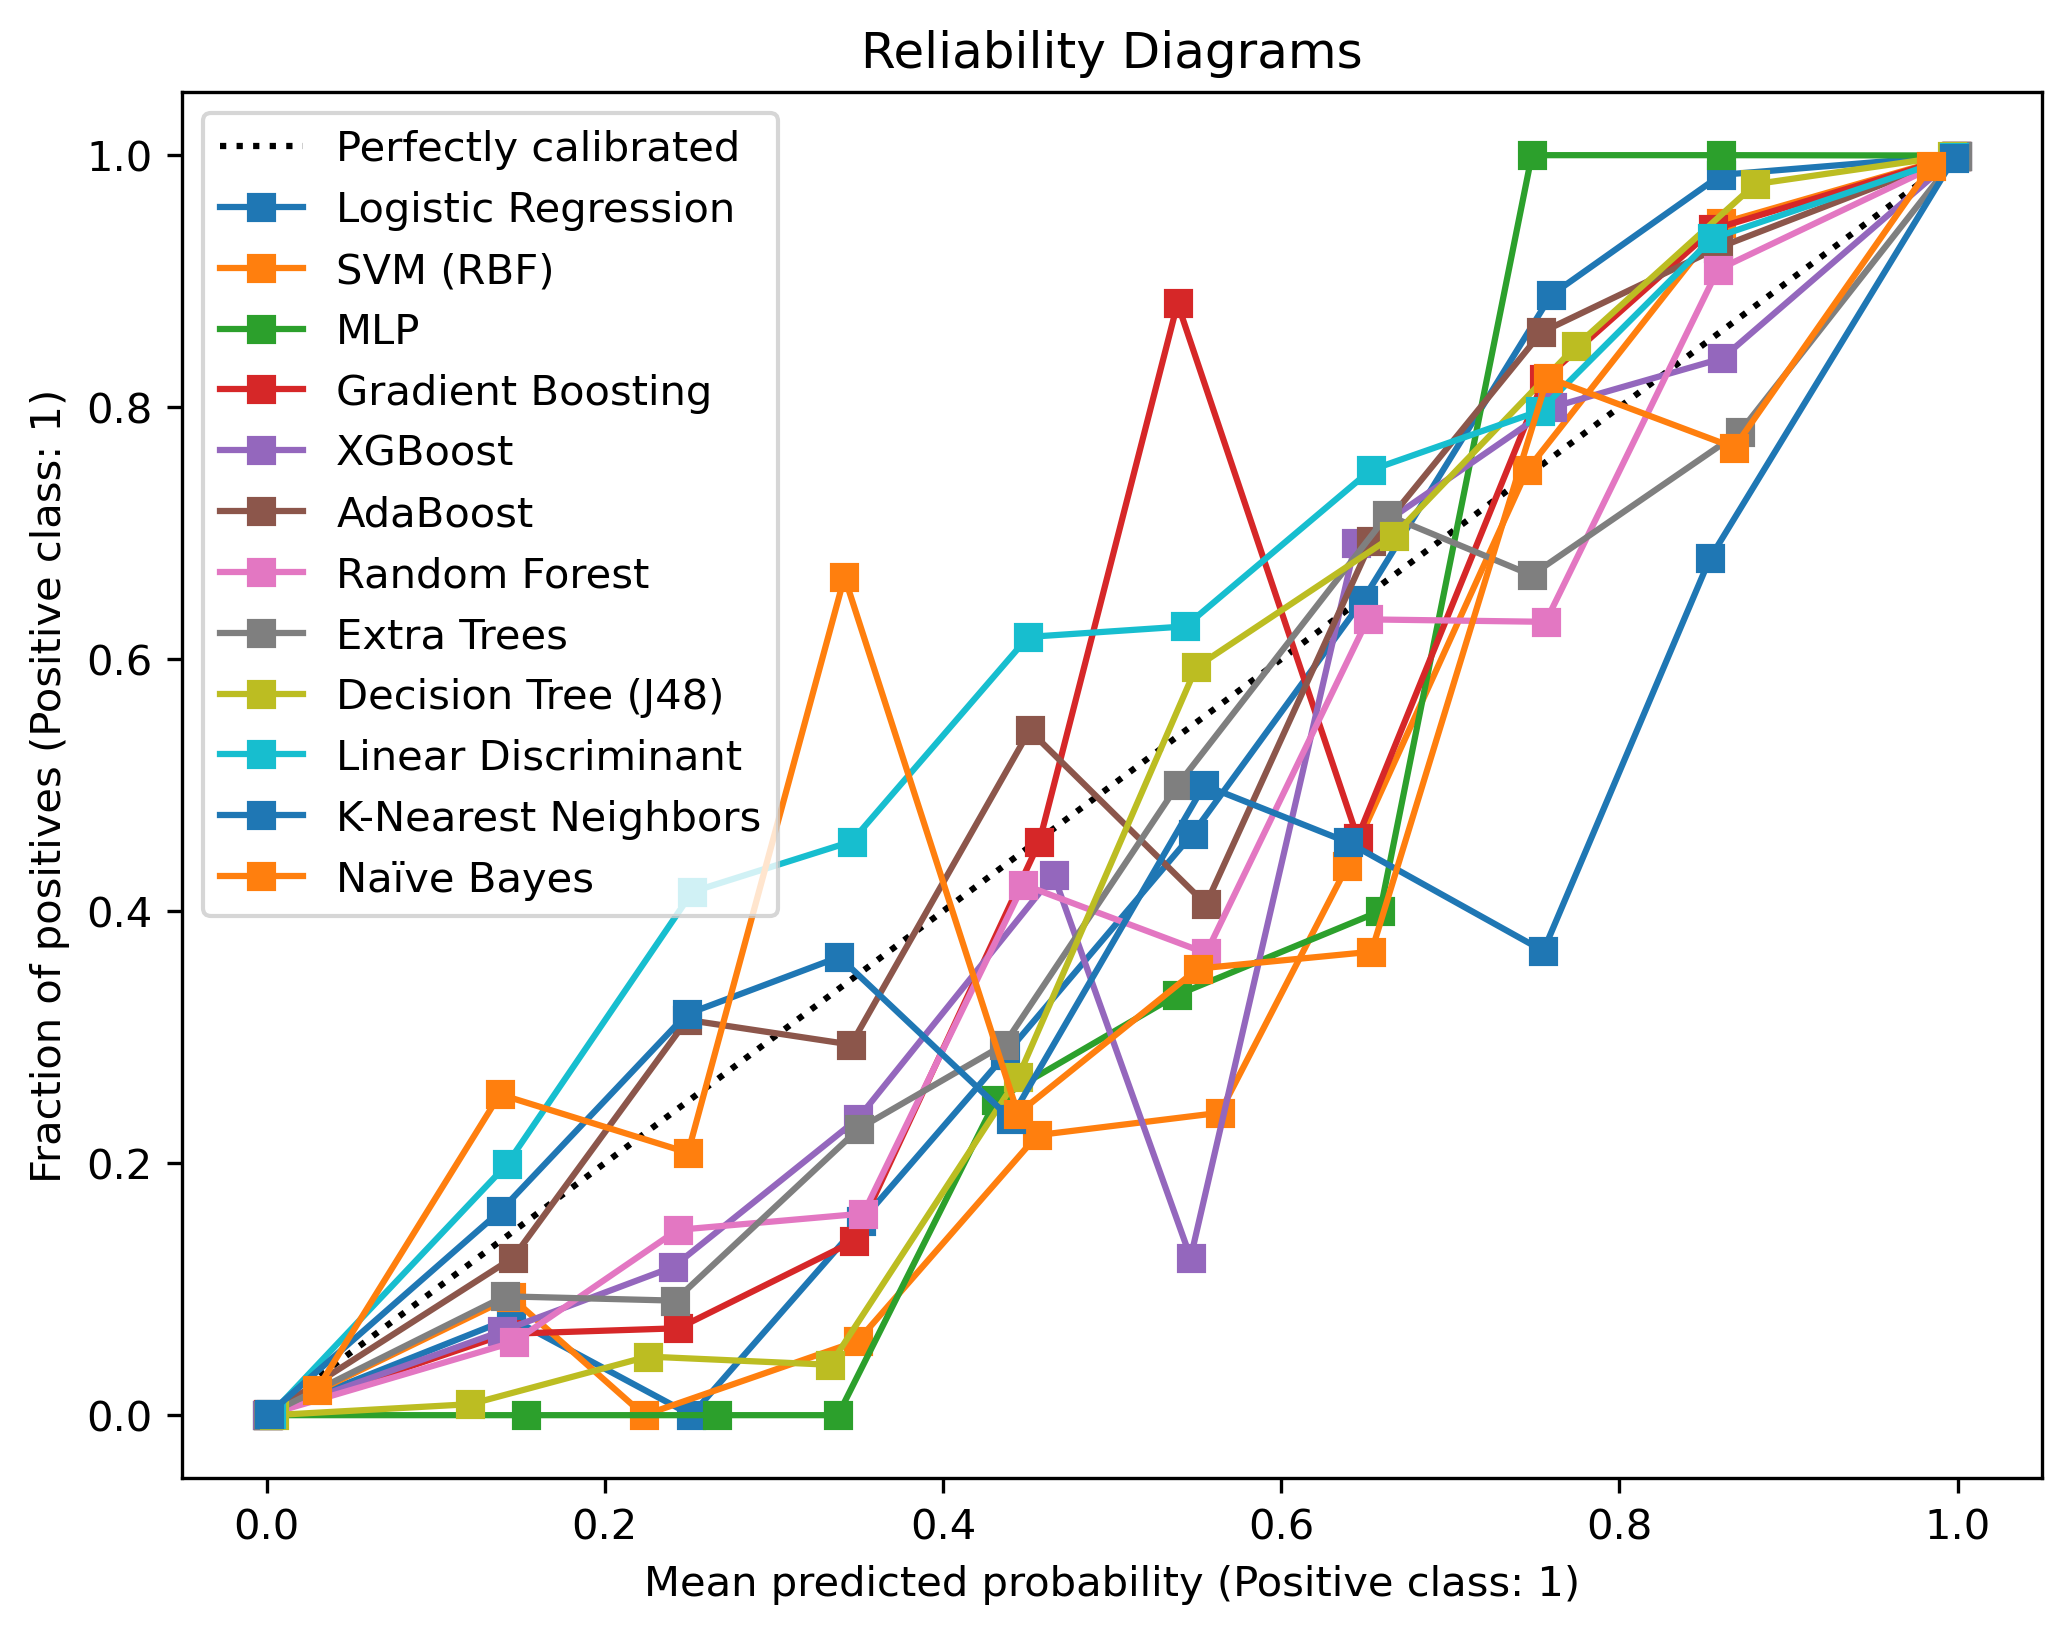

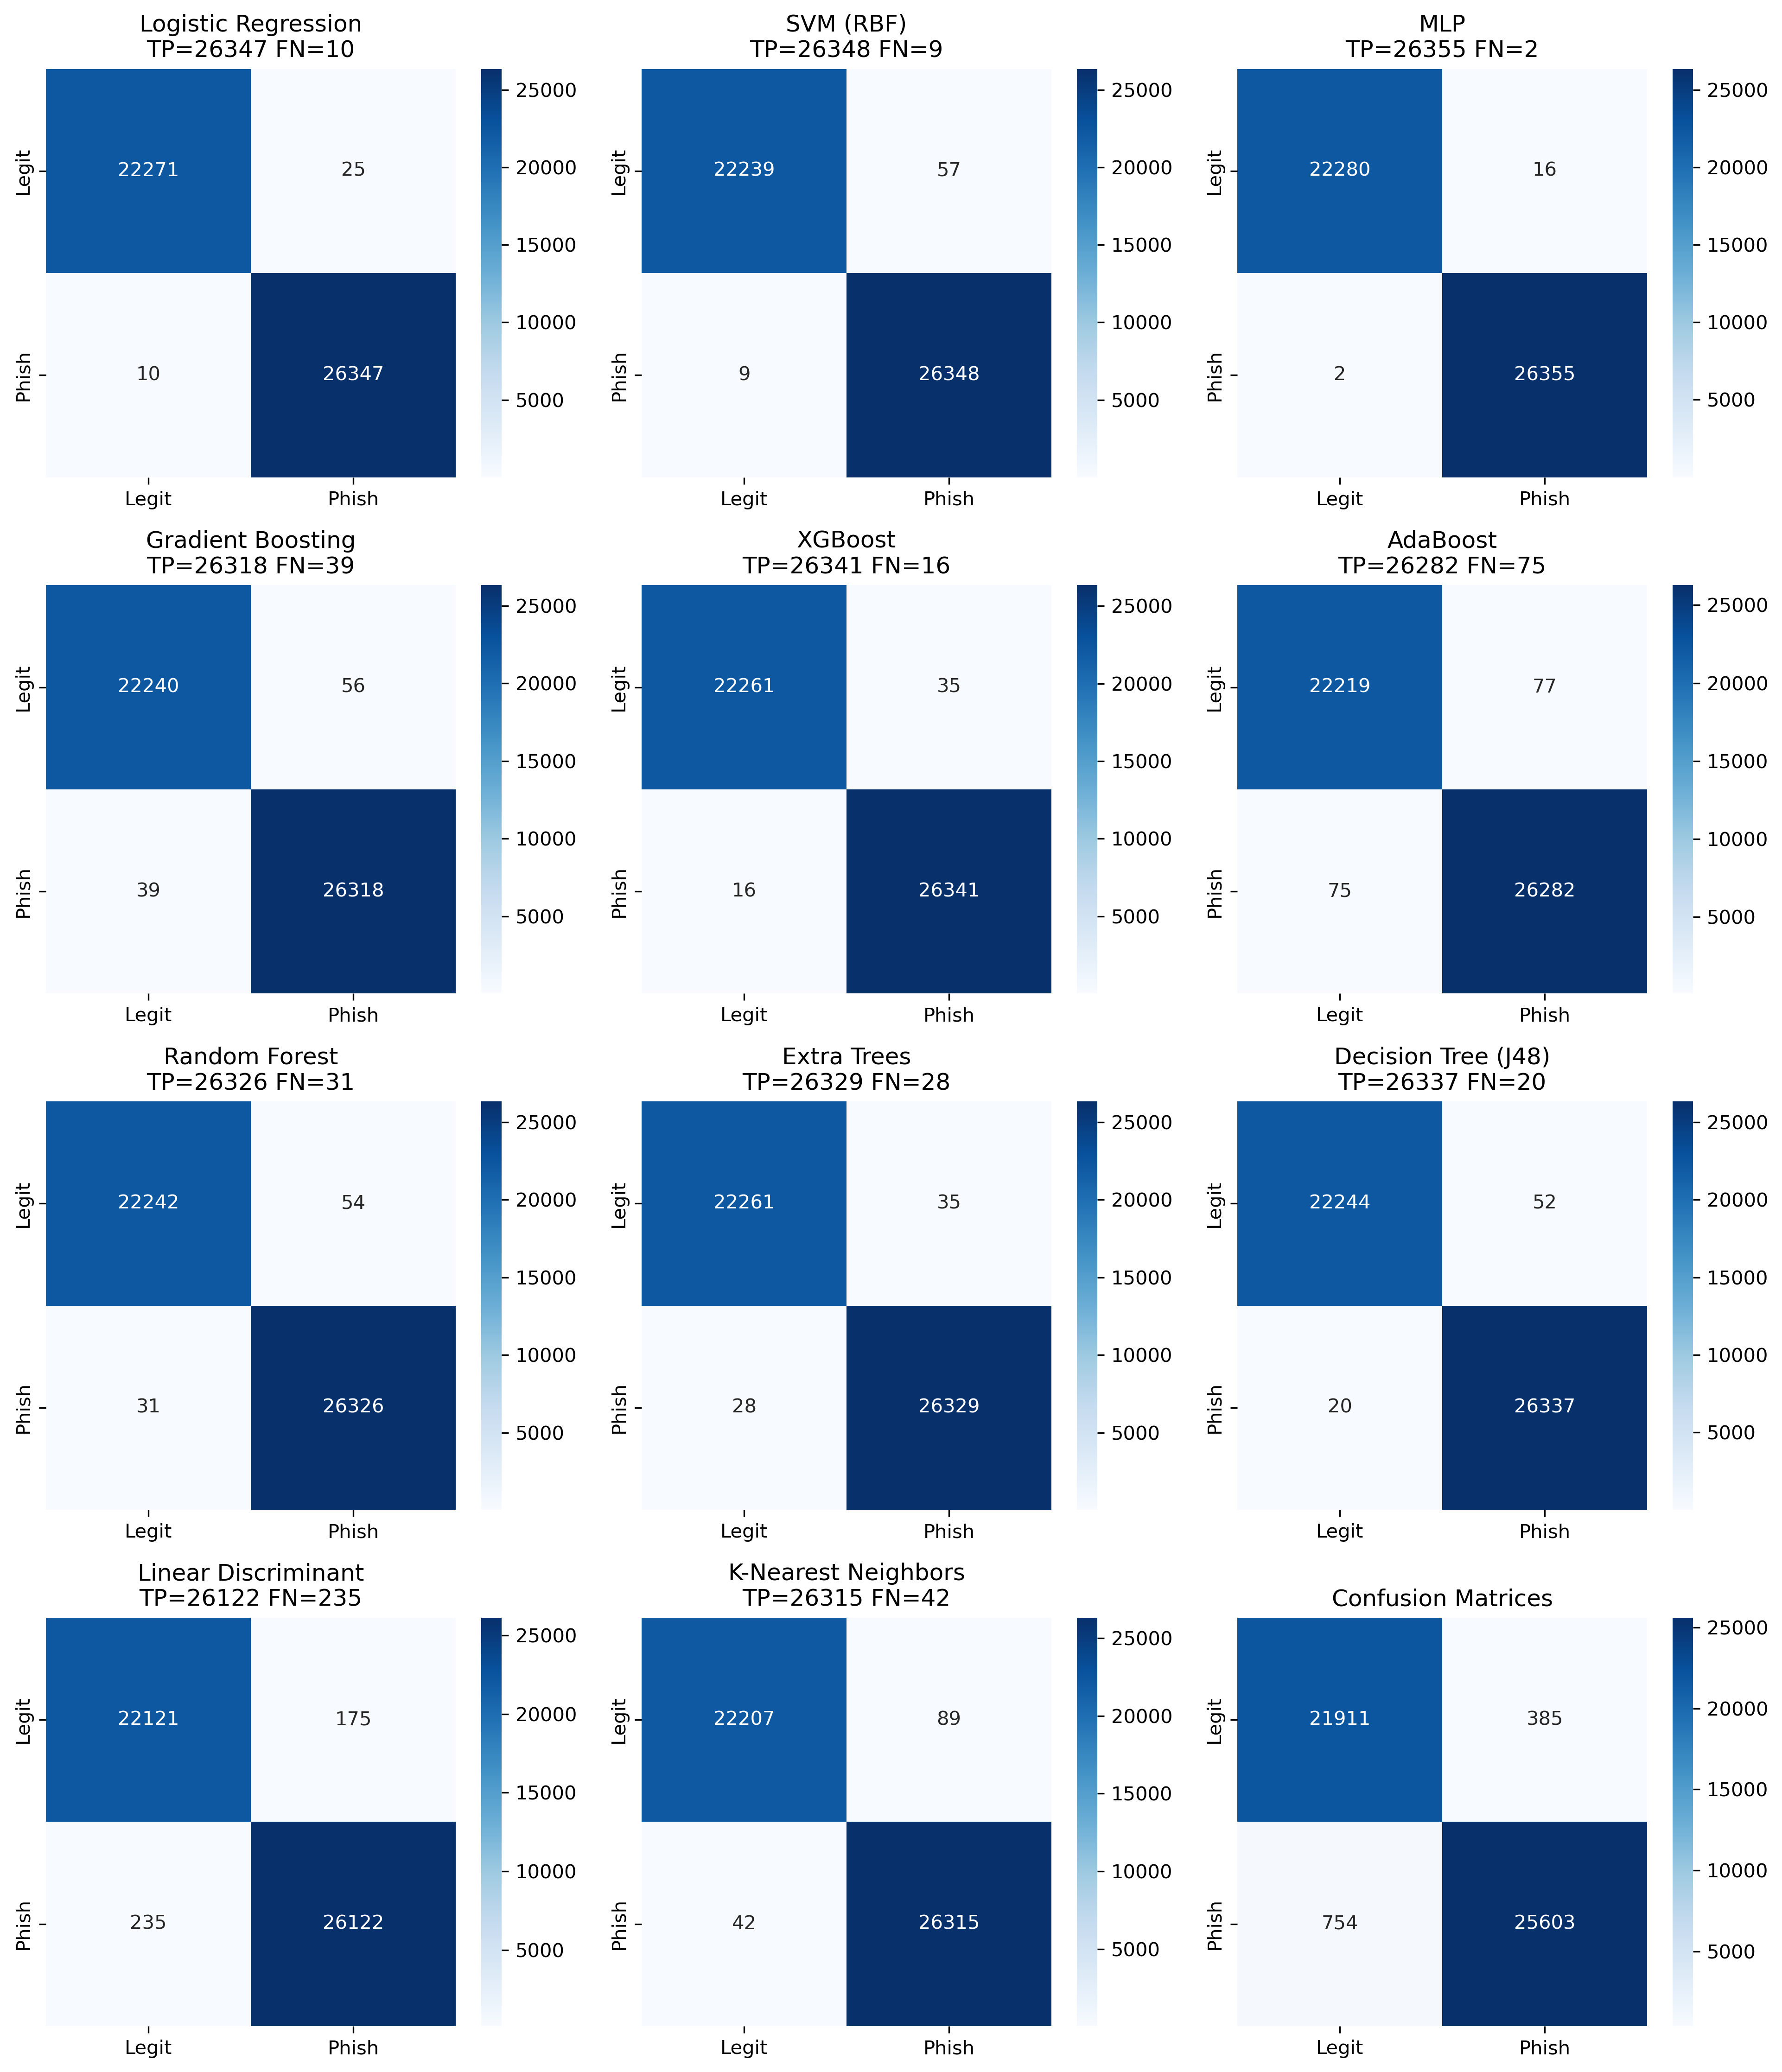

In [17]:
plt.figure(figsize=(10, 6), dpi=300)
top10 = results_df["Model"].tolist()

for name in top10:
    df_pred = pd.read_csv(RESULTS_DIR / f"predictions_{name}.csv")
    RocCurveDisplay.from_predictions(df_pred['y_true'], df_pred['y_proba'], name=name, ax=plt.gca())
plt.title("ROC Curves (Test Set – Domain-Strict Split)")
plt.savefig(RESULTS_DIR / "roc_curves.png", bbox_inches='tight')
plt.show()

# Calibration plots
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
for name in top10:
    df_pred = pd.read_csv(RESULTS_DIR / f"predictions_{name}.csv")
    CalibrationDisplay.from_predictions(df_pred['y_true'], df_pred['y_proba'], n_bins=10,
                                        name=name, ax=ax)
plt.title("Reliability Diagrams")
plt.legend(loc='best')
plt.savefig(RESULTS_DIR / "calibration.png", bbox_inches='tight')
plt.show()

# Confusion matrices (absolute counts)
fig, axes = plt.subplots(4, 3, figsize=(13, 15), dpi=300)
axes = axes.flatten()   # <--- important

for idx, name in enumerate(top10):
    df_pred = pd.read_csv(RESULTS_DIR / f"predictions_{name}.csv")
    cm = confusion_matrix(df_pred['y_true'], df_pred['y_pred'])
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
        xticklabels=['Legit', 'Phish'], yticklabels=['Legit', 'Phish']
    )
    axes[idx].set_title(f"{name}\nTP={cm[1,1]} FN={cm[1,0]}")

plt.tight_layout()
plt.title("Confusion Matrices")
plt.savefig(RESULTS_DIR / "confusion_matrices.png")
plt.show()

# ------------------- 8. Full Results + Hashes --------------------

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("ROC-AUC", ascending=False).reset_index(drop=True)

# Scale errors from 0 to 1 for bar plot
max_errors = results_df["Errors"].max()
results_df["Errors_Scaled"] = results_df["Errors"] / max_errors


print("\n" + "="*80)
print("FINAL RESULTS – STRICT DOMAIN SPLIT + ISOTONIC CALIBRATION + NO LEAKAGE")
print("="*80)
display(results_df)

# Save master table
results_df.to_csv(RESULTS_DIR / "final_results_calibrated.csv", index=False)
print(f"\nAll results saved to {RESULTS_DIR}/")


FINAL RESULTS – STRICT DOMAIN SPLIT + ISOTONIC CALIBRATION + NO LEAKAGE


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC,Brier,FNR (%),FPR (%),Errors,TP/TN/FP/FN,Errors_Scaled
0,Logistic Regression,0.99928,0.99905,0.99962,0.99934,0.99998,0.99998,0.00064,0.038,0.112,35,26347/22271/25/10,0.030729
1,SVM (RBF),0.99864,0.99784,0.99966,0.99875,0.99998,0.99999,0.00091,0.034,0.256,66,26348/22239/57/9,0.057946
2,MLP,0.99963,0.99939,0.99992,0.99966,0.99997,0.99997,0.00030,0.008,0.072,18,26355/22280/16/2,0.015803
3,Gradient Boosting,0.99805,0.99788,0.99852,0.99820,0.99996,0.99996,0.00159,0.148,0.251,95,26318/22240/56/39,0.083406
4,XGBoost,0.99895,0.99867,0.99939,0.99903,0.99994,0.99995,0.00085,0.061,0.157,51,26341/22261/35/16,0.044776
5,AdaBoost,0.99688,0.99708,0.99715,0.99712,0.99993,0.99993,0.00226,0.285,0.345,152,26282/22219/77/75,0.133450
6,Random Forest,0.99825,0.99795,0.99882,0.99839,0.99992,0.99992,0.00131,0.118,0.242,85,26326/22242/54/31,0.074627
7,Extra Trees,0.99871,0.99867,0.99894,0.99881,0.99992,0.99992,0.00111,0.106,0.157,63,26329/22261/35/28,0.055312
8,Decision Tree (J48),0.99852,0.99803,0.99924,0.99863,0.99981,0.99983,0.00148,0.076,0.233,72,26337/22244/52/20,0.063213
9,Linear Discriminant,0.99157,0.99335,0.99108,0.99221,0.99972,0.99975,0.00596,0.892,0.785,410,26122/22121/175/235,0.359965



All results saved to results/


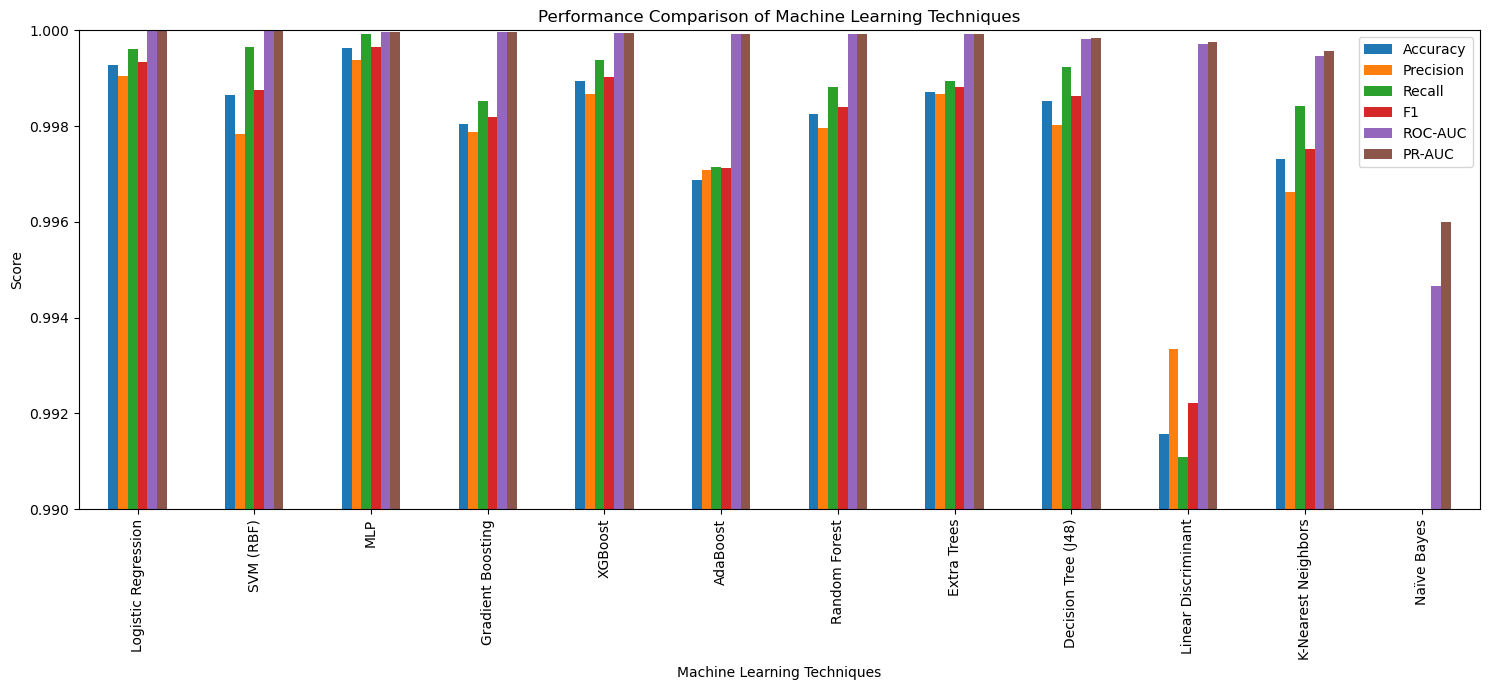

In [19]:
results_df.plot(x='Model', y=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC'], kind='bar', figsize=(15, 7))
plt.title('Performance Comparison of Machine Learning Techniques')
plt.ylabel('Score')
plt.xlabel('Machine Learning Techniques')
plt.ylim(0.99, 1.0)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

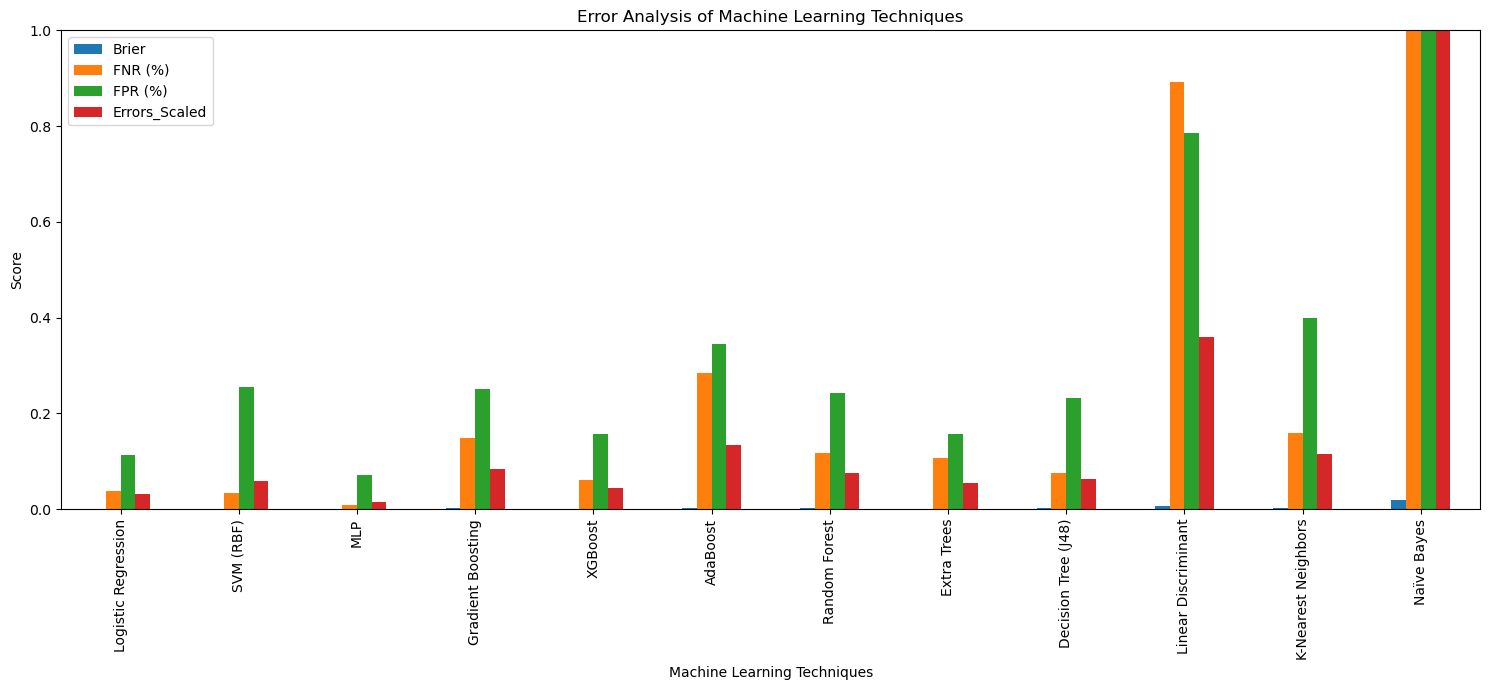

In [20]:
results_df.plot(x='Model', y=['Brier', 'FNR (%)', 'FPR (%)', 'Errors_Scaled'], kind='bar', figsize=(15, 7))
plt.title('Error Analysis of Machine Learning Techniques')
plt.ylabel('Score')
plt.xlabel('Machine Learning Techniques')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig(RESULTS_DIR / "model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# ------------------ 9. Ablation Studies -------------------

In [33]:
print("\nRunning ablation studies...")
ablation_results = []

# Baseline (best model)
best_model_name = results_df.iloc[0]["Model"]
cfg = models_config[best_model_name]
base_pipe = get_pipeline(cfg["model"], cfg["smote"], cfg["pca"])
base_pipe.fit(X_train_raw, y_train)
base_auc = roc_auc_score(y_test, base_pipe.predict_proba(X_test_raw)[:, 1])

ablation_results.append({"Variant": "Full", "ROC-AUC": base_auc})

# No SMOTE
if cfg["smote"]:
    pipe_nosmote = get_pipeline(cfg["model"], use_smote=False, use_pca=cfg["pca"])
    pipe_nosmote.fit(X_train_raw, y_train)
    ablation_results.append({"Variant": "No SMOTE", "ROC-AUC": roc_auc_score(y_test, pipe_nosmote.predict_proba(X_test_raw)[:, 1])})

# No PCA
if cfg["pca"]:
    pipe_nopca = get_pipeline(cfg["model"], cfg["smote"], use_pca=False)
    pipe_nopca.fit(X_train_raw, y_train)
    ablation_results.append({"Variant": "No PCA", "ROC-AUC": roc_auc_score(y_test, pipe_nopca.predict_proba(X_test_raw)[:, 1])})

# No SMOTE + No PCA
if cfg["smote"] and cfg["pca"]:
    pipe_smotepca = get_pipeline(cfg["model"], use_smote=False, use_pca=False)
    pipe_smotepca.fit(X_train_raw, y_train)
    ablation_results.append({"Variant": "NoSMOTE + No PCA", "ROC-AUC": roc_auc_score(y_test, pipe_smotepca.predict_proba(X_test_raw)[:, 1])})


pd.DataFrame(ablation_results).to_csv(RESULTS_DIR / "ablation.csv", index=False)
print(pd.DataFrame(ablation_results))


Running ablation studies...
            Variant   ROC-AUC
0              Full  0.999984
1          No SMOTE  0.999979
2            No PCA  0.999991
3  NoSMOTE + No PCA  0.999986


# ------------------ 10. Voting Classifier -------------------

In [22]:
# Voting Classifier Ensemble (Top 5 models)
from sklearn.ensemble import VotingClassifier
top5_models = results_df.head(5)["Model"].tolist()
estimators = []
for name in top5_models:
    cfg = models_config[name]
    pipe = get_pipeline(cfg["model"], use_smote=cfg["smote"], use_pca=cfg["pca"])
    pipe.fit(X_train_raw, y_train)
    estimators.append((name, pipe))
voting_clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
voting_clf.fit(X_train_raw, y_train)
voting_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test_raw)[:, 1])
print(f"\nVoting Classifier (Top 5) ROC-AUC: {voting_auc:.5f}")


Voting Classifier (Top 5) ROC-AUC: 0.99999


In [23]:
# Save best model, Voting Classifier and pipelines
import joblib
best_model_pipe = get_pipeline(cfg["model"], use_smote=cfg["smote"], use_pca=cfg["pca"])
best_model_pipe.fit(X_train_raw, y_train)
joblib.dump(best_model_pipe, RESULTS_DIR / f"best_model_{best_model_name.replace(' ', '_')}.joblib")
joblib.dump(voting_clf, RESULTS_DIR / "voting_classifier_top5.joblib")
print(f"\nBest model and Voting Classifier saved to {RESULTS_DIR}/")
print("Preprocessing complete.")


Best model and Voting Classifier saved to results/
Preprocessing complete.
